In [2]:
# using Pkg
# Pkg.add("OrdinaryDiffEq")
# Pkg.add("MAT")
# Pkg.add("CairoMakie")
# Pkg.add("LaTeXStrings")

In [1]:
using OrdinaryDiffEq
using CairoMakie
using LaTeXStrings
using LinearAlgebra
using Printf
using MAT

# Polynomials

In [2]:
# Model parameters defined as constants
const g = 1.0 # gravity constant
const L = 1.0 # length of pendulum
const b = 0.0 # damping coefficient
const m = 1.0 # mass of pendulum

# ODE RHS
function simplependulum!(dx,x,p,t)
    dx[1] = x[2]
    dx[2] = -(g/L)*sin(x[1]) - b/m*x[2]
    nothing
end;

In [76]:
#Initial condition and simulation time span
x0 = [0.9*π, 0]
t0 = 0
te = 20
dt = 0.01

#Define ODE problem and solve
prob = ODEProblem(simplependulum!, x0, (t0, te));
sol = solve(prob, Tsit5(), saveat=dt);

# read solution
x, t = reduce(hcat, sol.u), sol.t;

# Estimate frequencey of the system
dist_x0 = sum((x[:, 500:end] .- x0).^2, dims=1)[1,:]
i_close = sortperm(dist_x0, by=abs)[1] + 499
T = (i_close - 1) * dt

print("Period: ")
println(T)

Period:
13.02


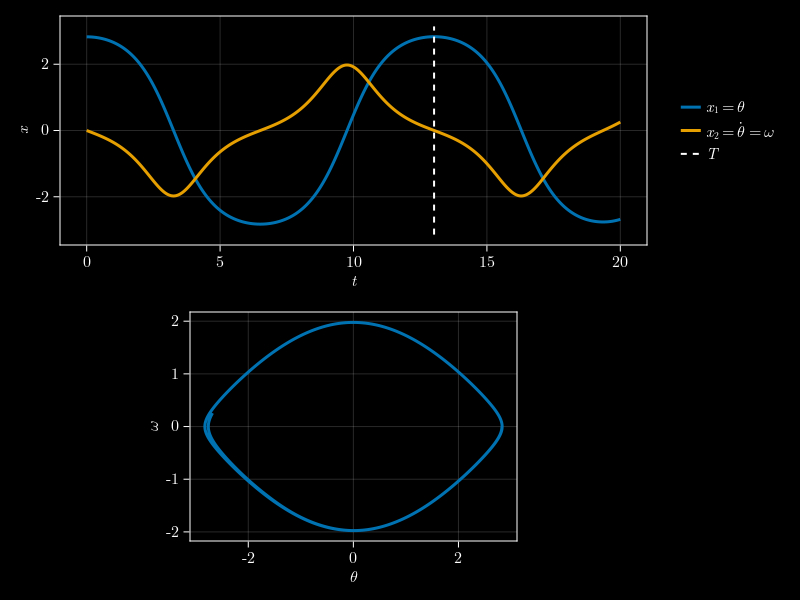

In [86]:
# Plot

# set theme
dark_latexfonts = merge(theme_black(), theme_latexfonts())
set_theme!(dark_latexfonts)

f = Figure()
ax = Axis(f[1, 1], xlabel = L"t", ylabel = L"x")
lines!(ax, t, x[1, :], label=L"x_1 = \theta", linewidth=3)
lines!(ax, t, x[2, :], label=L"x_2 = \dot{\theta}=\omega", linewidth=3)
lines!(ax, [T, T], [-π, π], label=L"T", linewidth=2, color=:white, linestyle=:dash)
f[1, 2] = Legend(f, ax, framevisible = false)
ax = Axis(f[2, 1], xlabel = L"\theta", ylabel = L"\omega", aspect=DataAspect())
lines!(ax, x[1, :], x[2, :], linewidth=3)
f

In [187]:
# DMD

# Data matrices
Z = x[:, 1 : end - 1]
Z_dash = x[:, 2 : end]

# For such a small system, SVD makes no sense
# Instead, we simply perform OLS and use the 
# pseudo inverse: Z' = A * Z <=> A = Z' * pinv(Z)
A = Z_dash * pinv(Z)

# Eigenvalues of A
μ = eigvals(A)
println("Eigenvalues:")
println(μ[1])
println(μ[2])

# Frequency
ω = abs(imag(log(μ[1]) / (nDelay * dt)))
print("\nFrequency = ")
println(ω)

# Stability
print("\nStability = ")
println(abs(μ[1]))

# Period estimated from the learned model
T_lin = 2 * π / ω
print("\nPeriod = ")
println(T_lin)

# Compare trajectories
x_lin = zeros(size(x))
x_lin[:, 1] = x0
for i in 1 : size(x, 2) - 1
    x_lin[:, i + 1] = A * x_lin[:, i]
end

Eigenvalues:
0.9999699266131827 - 0.004962701938487668im
0.9999699266131827 + 0.004962701938487668im

Frequency = 0.4962810444003826

Stability = 0.9999822411129632

Period = 12.66053857602211


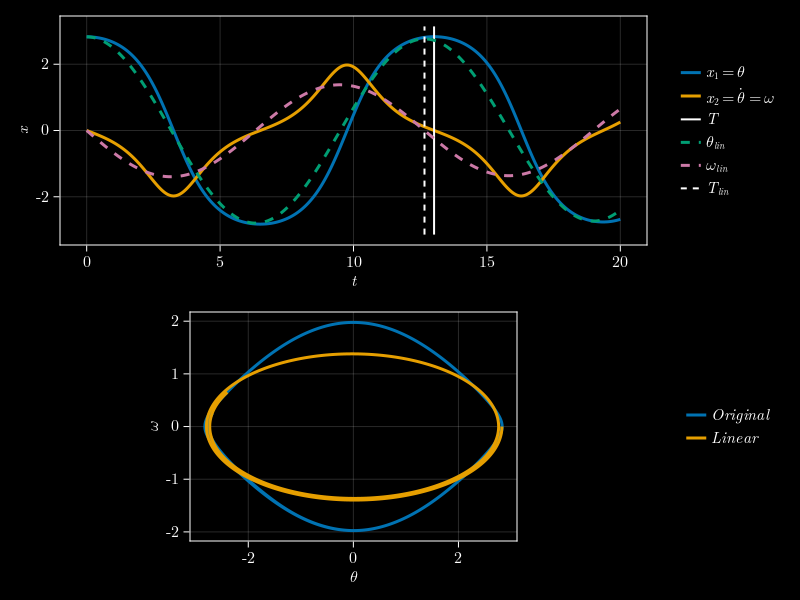

In [188]:
# Plot
f = Figure()
ax = Axis(f[1, 1], xlabel = L"t", ylabel = L"x")
lines!(ax, t, x[1, :], label=L"x_1 = \theta", linewidth=3)
lines!(ax, t, x[2, :], label=L"x_2 = \dot{\theta}=\omega", linewidth=3)
lines!(ax, [T, T], [-π, π], label=L"T", linewidth=2, color=:white)
lines!(ax, t, x_lin[1, :], label=L"\theta_{lin}", linewidth=3, linestyle=:dash)
lines!(ax, t, x_lin[2, :], label=L"\omega_{lin}", linewidth=3, linestyle=:dash)
lines!(ax, [T_lin, T_lin], [-π, π], label=L"T_{lin}", linewidth=2, color=:white, linestyle=:dash)
f[1, 2] = Legend(f, ax, framevisible = false)
ax = Axis(f[2, 1], xlabel = L"\theta", ylabel = L"\omega", aspect=DataAspect())
lines!(ax, x[1, :], x[2, :], linewidth=3, label=L"Original")
lines!(ax, x_lin[1, :], x_lin[2, :], linewidth=3, label=L"Linear")
f[2, 2] = Legend(f, ax, framevisible = false)
f

In [189]:
# lift to polynomials of degree p

# The function lifts the input matrix Z to PsiZ.
# The array iy denotes the indices for projecting PsiZ to Z.
function psi(Z, p)
    nPoly = binomial(2 + p, p)
    PsiZ = ones((nPoly, size(Z, 2)))
    PsiZ[2:3, :] = Z

    s = 4
    for jj in 2 : p
        for ii in 0 : jj
            PsiZ[s, :] = Z[2, :].^ii .* Z[1, :].^(jj - ii)
            s += 1
        end
    end
    return PsiZ
end;

In [190]:
p = 3
PsiZ = psi(Z, p)
PsiZ_dash = psi(Z_dash, p)
print("dim(Psi(z)) = ")
println(size(PsiZ,1))

A2 = PsiZ_dash * pinv(PsiZ)

# Eigenvalues of A
μ2 = eigvals(A2)

# Frequencies
ω2 = abs.(imag.(log.(μ2) ./ (nDelay * dt)))
print("\nFrequencies: ")
println(ω2)

# Stability
print("\nStability: ")
println(abs.(μ2))

# Period estimated from the learned model
T_lin2 = 2 .* π ./ ω2
print("\nPeriod: ")
println(T_lin2)

# Compare trajectories
PsiZ_lin = zeros(size(PsiZ, 1), size(x, 2))
PsiZ_lin[:, 1] = PsiZ[:, 1]
for i in 1 : size(x, 2) - 1
    PsiZ_lin[:, i + 1] = A2 * PsiZ_lin[:, i]
end
x_lin2 = PsiZ_lin[2:3, :];

dim(Psi(z)) = 10

Frequencies: [0.0, 2.723882741517962, 2.723882741517962, 1.4763025680638797, 1.4763025680638797, 1.1536635662583614, 1.1536635662583614, 0.48778066706645395, 0.48778066706645395, 0.0]

Stability: [0.9993141450812977, 0.9999432461777794, 0.9999432461777794, 0.9999492845215532, 0.9999492845215532, 1.0000496016941975, 1.0000496016941975, 0.9999982491213512, 0.9999982491213512, 1.0000000000000029]

Period: [Inf, 2.3067018309599114, 2.3067018309599114, 4.256028163264506, 4.256028163264506, 5.44628910103977, 5.44628910103977, 12.881169204526062, 12.881169204526062, Inf]


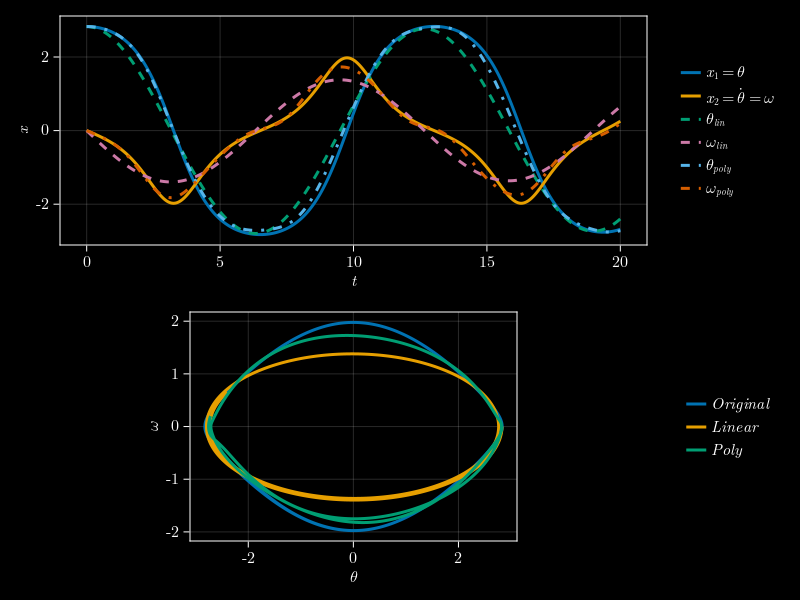

In [191]:
# Plot
f = Figure()
ax = Axis(f[1, 1], xlabel = L"t", ylabel = L"x")
lines!(ax, t, x[1, :], label=L"x_1 = \theta", linewidth=3)
lines!(ax, t, x[2, :], label=L"x_2 = \dot{\theta}=\omega", linewidth=3)
lines!(ax, t, x_lin[1, :], label=L"\theta_{lin}", linewidth=3, linestyle=:dash)
lines!(ax, t, x_lin[2, :], label=L"\omega_{lin}", linewidth=3, linestyle=:dash)
lines!(ax, t, x_lin2[1, :], label=L"\theta_{poly}", linewidth=3, linestyle=:dashdot)
lines!(ax, t, x_lin2[2, :], label=L"\omega_{poly}", linewidth=3, linestyle=:dashdot)
f[1, 2] = Legend(f, ax, framevisible = false)
ax = Axis(f[2, 1], xlabel = L"\theta", ylabel = L"\omega", aspect=DataAspect())
lines!(ax, x[1, :], x[2, :], linewidth=3, label=L"Original")
lines!(ax, x_lin[1, :], x_lin[2, :], linewidth=3, label=L"Linear")
lines!(ax, x_lin2[1, :], x_lin2[2, :], linewidth=3, label=L"Poly")
f[2, 2] = Legend(f, ax, framevisible = false)
f

In [216]:
p3 = 10
PsiZ3 = psi(Z, p3)
PsiZ3_dash = psi(Z_dash, p3)
print("dim(Psi(z)) = ")
println(size(PsiZ3, 1))

# SVD
U, S, V = svd(PsiZ3);

# rank of reduced matrix
r = 22;

# DMD with many features and SVD
A_tilde = U[:, 1 : r]' * PsiZ3_dash * V[:, 1 : r] * diagm( 1 ./ S[1 : r] );

# Eigenvalues of A
μ3 = eigvals(A_tilde)

# Frequencies
ω3 = abs.(imag.(log.(μ3) ./ (nDelay * dt)))
print("\nFrequencies: ")
println(ω3)

# Stability
print("\nStability: ")
println(abs.(μ3))

# Period estimated from the learned model
T_lin3 = 2 .* π ./ ω3
print("\nPeriod: ")
println(T_lin3)

# Compare trajectories
PsiZ3_0 = U[:, 1 : r]' * PsiZ3[:, 1]
PsiZ3_lin = zeros(length(PsiZ3_0), size(x, 2))
PsiZ3_lin[:, 1] = PsiZ3_0
for i in 1 : size(x, 2) - 1
    PsiZ3_lin[:, i + 1] = A_tilde * PsiZ3_lin[:, i]
end
x_lin3 = (U[:, 1 : r] * PsiZ3_lin)[2:3, :];

dim(Psi(z)) = 66

Frequencies: [6.36201007604744, 6.36201007604744, 5.1829510780708885, 5.1829510780708885, 4.2632116495524075, 4.2632116495524075, 3.3949628312288724, 3.3949628312288724, 2.968475664904572, 2.968475664904572, 2.443466417571607, 2.443466417571607, 1.946175162960615, 1.946175162960615, 1.4578449225707995, 1.4578449225707995, 0.9715169702822433, 0.9715169702822433, 0.0, 0.4853850240350594, 0.4853850240350594, 0.0]

Stability: [0.9999164304003434, 0.9999164304003434, 0.999819630923973, 0.999819630923973, 0.9999393106757177, 0.9999393106757177, 0.9998318979283727, 0.9998318979283727, 0.9998897332965303, 0.9998897332965303, 0.9999213788972496, 0.9999213788972496, 0.9999508953992324, 0.9999508953992324, 0.9999633277440405, 0.9999633277440405, 0.9999689305722523, 0.9999689305722523, 0.999964879867305, 0.999980377945528, 0.999980377945528, 1.0018975523276732]

Period: [0.9876100842460743, 0.9876100842460743, 1.212279493388197, 1.212279493388197, 1.473815007012203, 1.47381500701

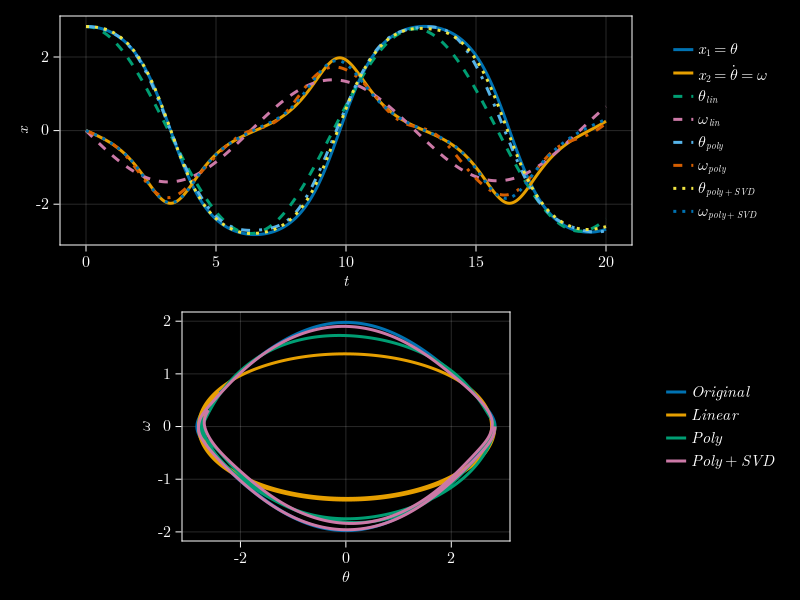

In [218]:
# Plot
f = Figure()
ax = Axis(f[1, 1], xlabel = L"t", ylabel = L"x")
lines!(ax, t, x[1, :], label=L"x_1 = \theta", linewidth=3)
lines!(ax, t, x[2, :], label=L"x_2 = \dot{\theta}=\omega", linewidth=3)
lines!(ax, t, x_lin[1, :], label=L"\theta_{lin}", linewidth=3, linestyle=:dash)
lines!(ax, t, x_lin[2, :], label=L"\omega_{lin}", linewidth=3, linestyle=:dash)
lines!(ax, t, x_lin2[1, :], label=L"\theta_{poly}", linewidth=3, linestyle=:dashdot)
lines!(ax, t, x_lin2[2, :], label=L"\omega_{poly}", linewidth=3, linestyle=:dashdot)
lines!(ax, t, x_lin3[1, :], label=L"\theta_{poly + SVD}", linewidth=3, linestyle=:dot)
lines!(ax, t, x_lin3[2, :], label=L"\omega_{poly + SVD}", linewidth=3, linestyle=:dot)
f[1, 2] = Legend(f, ax, framevisible = false)
ax = Axis(f[2, 1], xlabel = L"\theta", ylabel = L"\omega", aspect=DataAspect())
lines!(ax, x[1, :], x[2, :], linewidth=3, label=L"Original")
lines!(ax, x_lin[1, :], x_lin[2, :], linewidth=3, label=L"Linear")
lines!(ax, x_lin2[1, :], x_lin2[2, :], linewidth=3, label=L"Poly")
lines!(ax, x_lin3[1, :], x_lin3[2, :], linewidth=3, label=L"Poly + SVD")
f[2, 2] = Legend(f, ax, framevisible = false)
f

# SVD: Faces

In [37]:
# Read data from YaleFaces library
file = matopen("YaleFacesB.mat")
person_id = read(file, "person_id") 
Z = read(file, "X") 
close(file)

# dimensions of the images in pixels
d1 = 192;
d2 = 168;

println(size(Z))

(32256, 2414)


In [38]:
# function for finding a certain person's first images
function find_index(person)
    for i in 1 : size(Z, 2)
        if person_id[i] == person
            return i
        end
    end
    return -1
end;

# function for findin all images belonging to a person
function find_all_indices(person)
    i = Int(1)
    while person_id[i] != person
        i += 1
    end

    n = Int(0)
    indices = zeros(Int, 100)
    while person_id[i] == person
        n += 1
        indices[n] = i
        i += 1
    end
    
    return indices[1:n]
end;

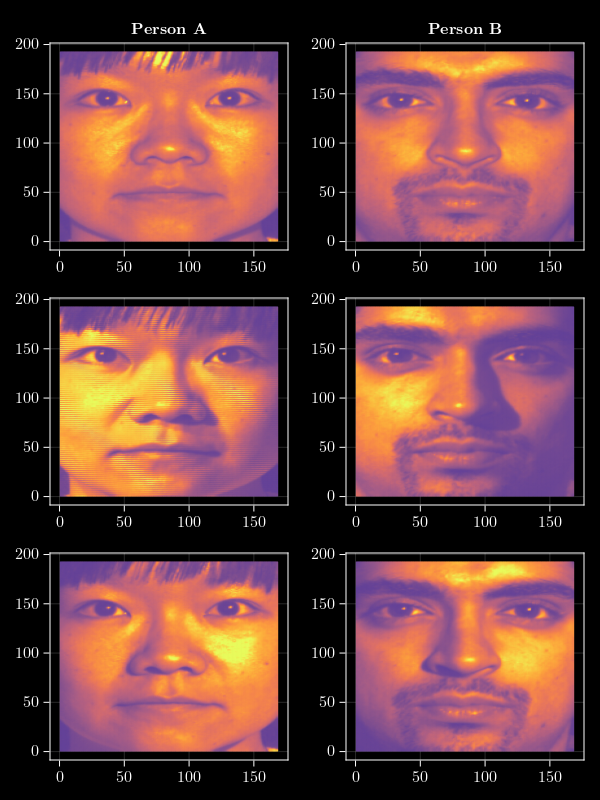

In [40]:
# plot two faces
person1 = 5
person2 = 9

iA = find_index(person1)
iB = find_index(person2)
nextIm1 = 15
nextIm2 = 40

# create coordinate matrices
s1 = LinRange(1, d2, d2);
s2 = LinRange(d1, 1, d1);
S1 = reduce(vcat, repeat(s1, 1, d1));
S2 = reduce(vcat, repeat(s2', d2, 1));

# normalize vector to [0.4, 1] for plotting purposes
function normalizeVector(x)
    lb = 0.4;
    dx = maximum(x) - minimum(x);
    return ((((x .- minimum(x)) ./ dx) .+ lb) ./ (1 + lb))
end;

# plot vector to 2D array

# add plot function
function add_ax(Z, i=1, j=1, titlestr="", ms=3, cmap=:thermal, xl="", yl="")
    ax = Axis(fig[i, j], backgroundcolor = "black", 
        title=titlestr, xlabel=xl, ylabel=yl)
    sc = scatter!(ax, S1, S2, color = normalizeVector(Z), 
        colorrange = (0,1), markersize = ms, colormap = cmap)
end

# plot a few faces
fig = Figure(resolution = (600, 800), backgroundcolor = "black")
add_ax(Z[:, iA], 1, 1, "Person A")
add_ax(Z[:, iA + nextIm1], 2, 1)
add_ax(Z[:, iA + nextIm2], 3, 1)
add_ax(Z[:, iB], 1, 2, "Person B")
add_ax(Z[:, iB + nextIm1], 2, 2)
add_ax(Z[:, iB + nextIm2], 3, 2)
fig

In [41]:
U, S, V = svd(Z);

println(size(U))
println(size(S))
println(size(V'))

(32256, 2414)
(2414,)
(2414, 2414)


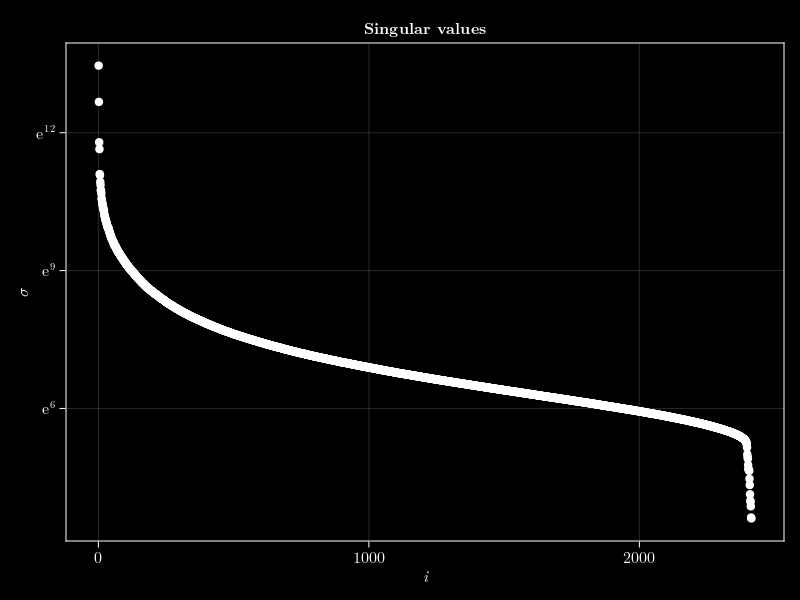

In [42]:
# Plot singular values
f = Figure()
ax = Axis(f[1, 1], xlabel = L"i", ylabel = L"\sigma", yscale=log,
    title="Singular values")
scatter!(ax, range(1,length(S),length=length(S)), S, color="white")
f

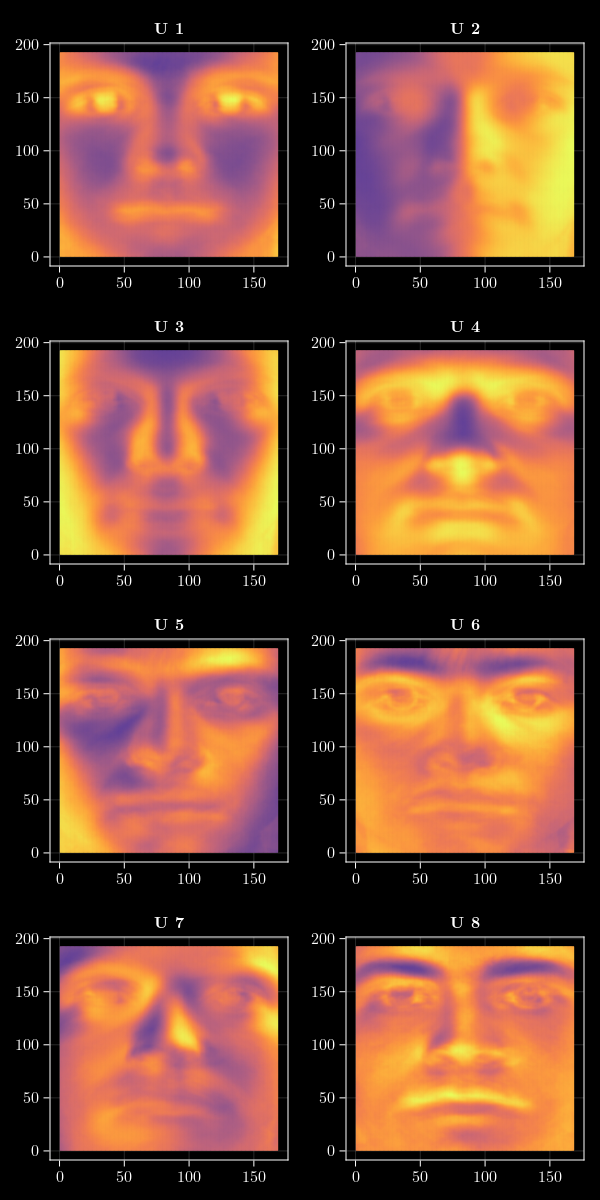

In [43]:
# Plot the first 16 singular vectors ("eigenfaces")
fig = Figure(resolution = (600, 1200), backgroundcolor = "black")
for i in 1 : 4
    for j in 1 : 2
        k = (i-1) * 2 + j
        add_ax(U[:, k], i, j, @sprintf("U %d", k))
    end
end
fig

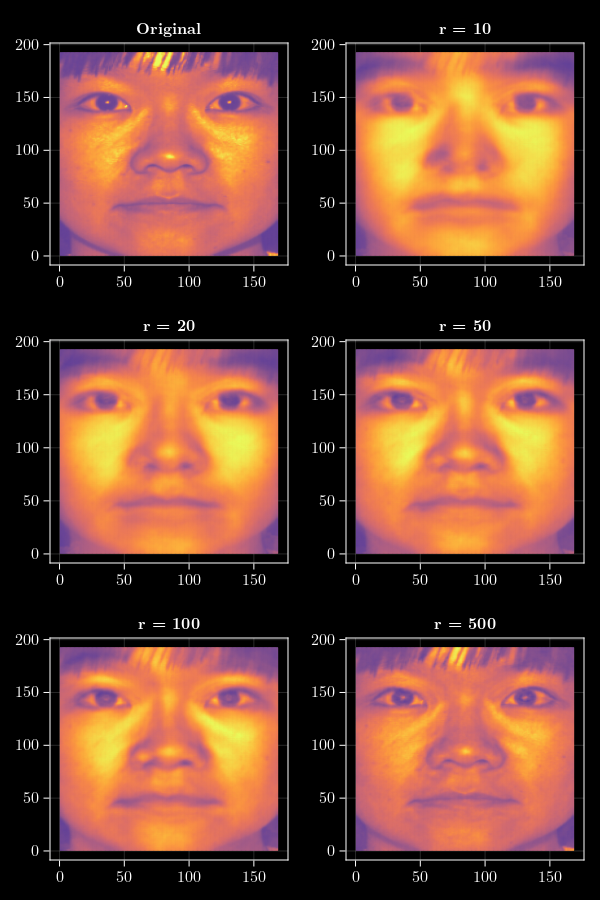

In [44]:
# Study the reconstruction quality
iA = find_index(person1)

# Find the coefficients of this particular face in terms of the basis U
a = U' * Z[:, iA]

# number of modes for reconstruction
r = [10, 20, 50, 100, 500]

# Plot the first 16 singular vectors ("eigenfaces")
fig = Figure(resolution = (600, 900), backgroundcolor = "black")
add_ax(Z[:, iA], 1, 1, "Original", 3)
for i in 1 : 3
    for j in 1 : 2
        k = (i-1) * 2 + j

        # don't plot in the first entry, as there we have the original
        if k == 1
            continue
        end

        # number of modes for reconstruction
        rk = r[k-1]

        # reconstruct image
        Zr = zeros(d1 * d2)
        for l in 1 : rk
            Zr += a[l] * U[:, l]
        end

        # plot reconstructed image
        add_ax(Zr, i, j, @sprintf("r = %d", r[k-1]))
    end
end
fig


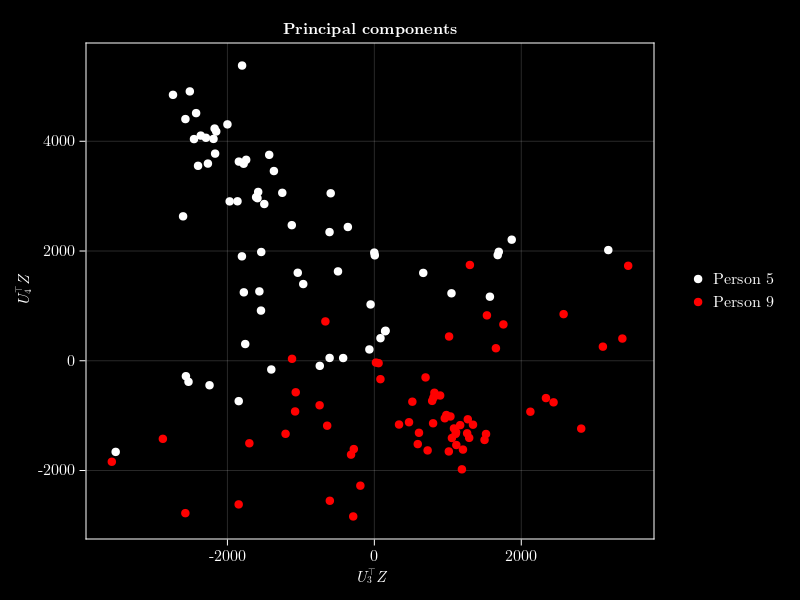

In [45]:
# Compare two people in terms of their basis coefficients

# principal components to Compare
PC1 = 5
PC2 = 6

# indices of the persons' pictures
ind1 = find_all_indices(person1)
ind2 = find_all_indices(person2)

# projection onto U basis
a1 = U' * Z[:, ind1];
a2 = U' * Z[:, ind2];

# plot two principal components
f = Figure()
ax = Axis(f[1, 1], xlabel = L"U_3^\top Z", ylabel = L"U_4^\top Z", 
    title="Principal components")
scatter!(ax, a1[PC1, :], a1[PC2, :], color="white", label=@sprintf("Person %d", person1))
scatter!(ax, a2[PC1, :], a2[PC2, :], color="red", label=@sprintf("Person %d", person2))
f[1, 2] = Legend(f, ax, framevisible = false)
f

# SVD: Vortex shedding

In [30]:
# Read vortex shedding data
file = matopen("VortexShedding.mat")
Z_all = read(file, "Z") 
ns1 = read(file, "nx") 
ns2 = read(file, "ny") 
close(file);
dt = 0.1;

# matwrite("VortexSheddingSmall.mat", Dict(
# 	"Z" => Z_all[:,1:50]); compress = true)

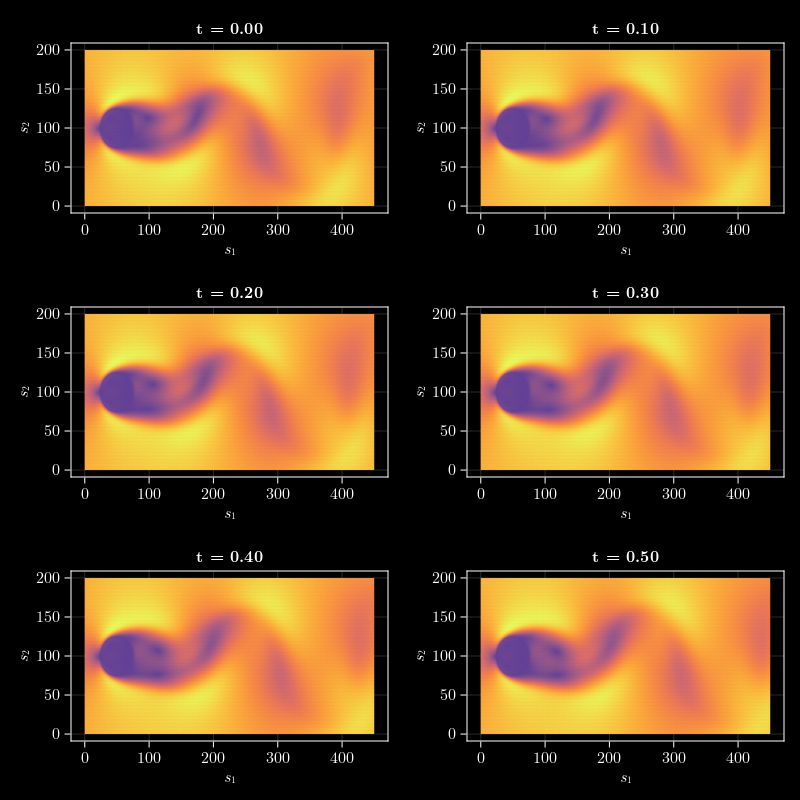

In [47]:
# plot a few snapshots

# create coordinate matrices
s1 = LinRange(1, ns1, ns1);
s2 = LinRange(1, ns2, ns2);
S1 = reduce(vcat, repeat(s1, 1, ns2));
S2 = reduce(vcat, repeat(s2', ns1, 1));

dark_latexfonts = merge(theme_black(), theme_latexfonts())
set_theme!(dark_latexfonts)

# normalize vector to [0.4, 1] for plotting purposes
function normalizeVector(x)
    dx = maximum(x) - minimum(x);
    return ((((x .- minimum(x)) ./ dx) .+ .4) ./ 1.4)
end;

# plot vector to 2D array
function add_ax2(Z, i=1, j=1, titlestr="", ms=3, cmap=:thermal)
    ax = Axis(fig[i, j], backgroundcolor = "black", 
        title=titlestr, xlabel=L"s_1", ylabel=L"s_2")
    sc = scatter!(ax, S2, S1, color = normalizeVector(Z), 
        colorrange = (0,1), markersize = ms, colormap = cmap)
end

fig = Figure(resolution = (800, 800), backgroundcolor = "black")
for i in 1 : 3
    for j in 1 : 2
        k = (i-1) * 2 + j
        add_ax2(Z_all[:, k], i, j, @sprintf("t = %.2f", (k-1) * dt), 2)
        # ax = Axis(fig[i, j], backgroundcolor = "black", 
        #     title=@sprintf("t = %.2f", (k-1) * dt), 
        #     xlabel=L"s_1", ylabel=L"s_2")
        # sc = scatter!(ax, S2, S1, color = Z_all[:, k], 
        #     markersize = 2, colormap = :thermal)
    end
end
fig

In [17]:
# # Create video

# # animation settings
# framerate = 10
# hue_iterator = range(1, size(Z, 2), length=size(Z, 2))

# fig = Figure(resolution = (1600, 800), backgroundcolor = "black")
# ax = Axis(fig[1, 1], backgroundcolor = "black", 
#     title=@sprintf("t = %.2f", 0), 
#     xlabel=L"s_1", ylabel=L"s_2")
# sc = scatter!(ax, S2, S1, color = Z[:, 1], 
#     markersize = 8, colormap = :thermal)

# record(fig, "VortexShedding.mp4", hue_iterator;
#         framerate = framerate) do hue
#     sc.color = Z[:, Int(hue)]
#     ax.title = @sprintf("t = %.2f", hue * dt);
# end

In [48]:
# Set up the regressor matrix for the identification of 
# a linear dynamical system
Z = Z_all[:, 1 : end - 1];
Z_dash = Z_all[:, 2 : end];

# Singular Value Decomposition (SVD) of the data
# (Julia automatically performs the economy version)
U, S, V = svd(Z);

println(size(U))
println(size(S))
println(size(V'))

(89351, 150)
(150,)
(150, 150)


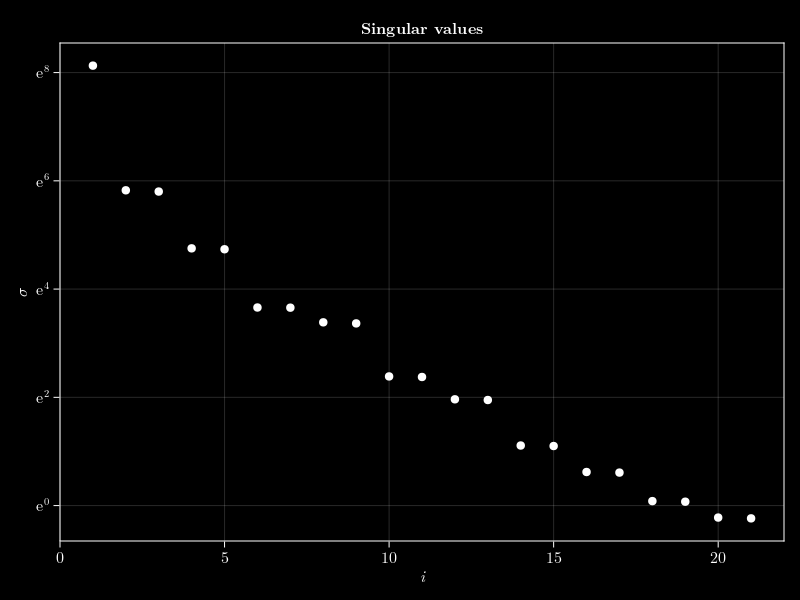

In [49]:
# Plot singular values
f = Figure()
ax = Axis(f[1, 1], xlabel = L"i", ylabel = L"\sigma", yscale=log,
    title="Singular values")
scatter!(ax, range(1,21,21), S[1:21], color="white")
f

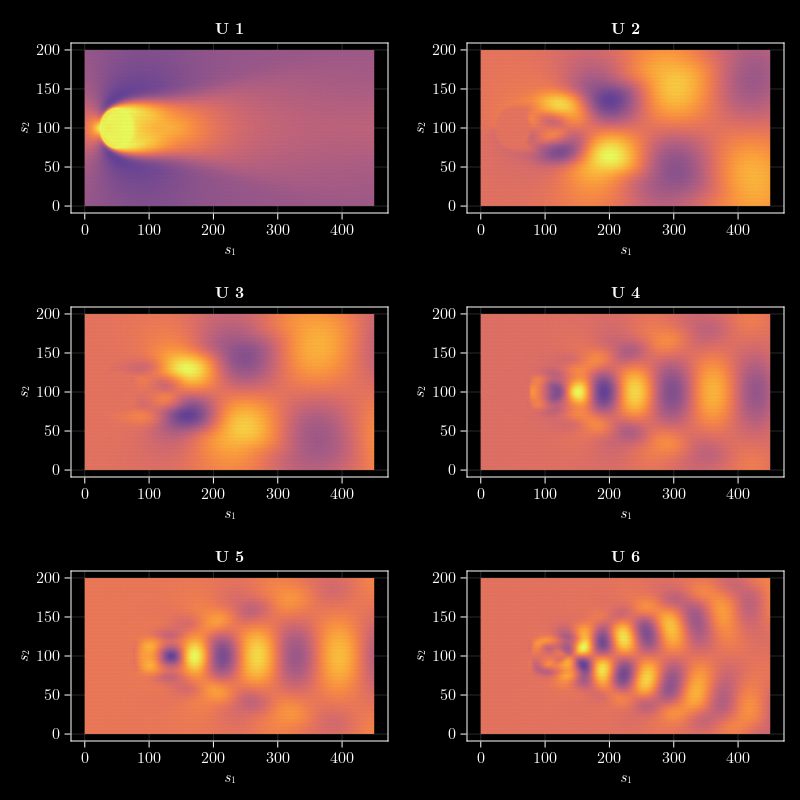

In [50]:
fig = Figure(resolution = (800, 800), backgroundcolor = "black")
for i in 1 : 3
    for j in 1 : 2
        k = (i-1) * 2 + j
        add_ax2(U[:, k], i, j, @sprintf("U %d", k), 2, :thermal)
    end
end
fig